# ARIMA
Exprimenting with ARIMA.<br>
Starting out with this tutorial: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ [1]<br>
Video that loops over different p,d,q (not rolling forecast though): https://www.youtube.com/watch?v=D9y6dcy0xK8 [2]


In [5]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [10, 8]

In [6]:
# Load data
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, sep=';',date_parser=parser)

/home/karen/code/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


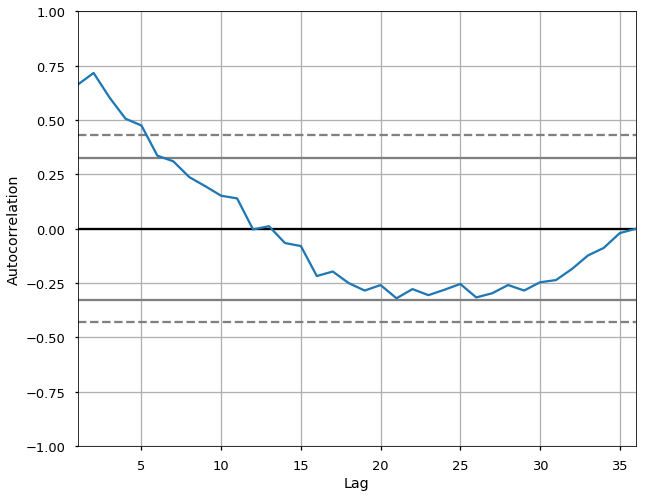

In [7]:
# Plot autocorrelation, with difference of 1 corresponding to the 'd' parameter = "degree of differencing"
autocorrelation_plot(series)
plt.show()

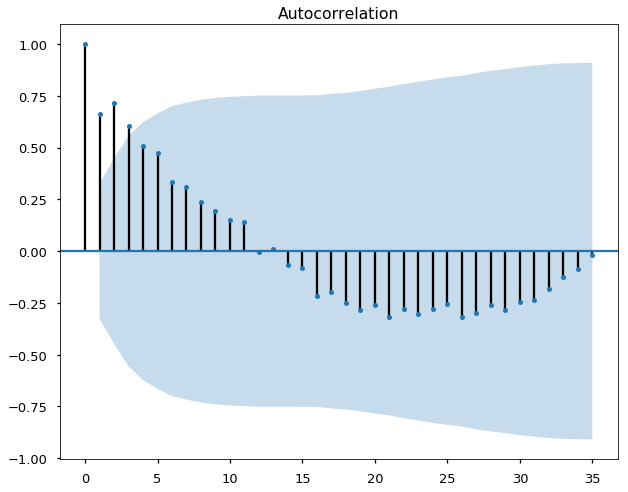

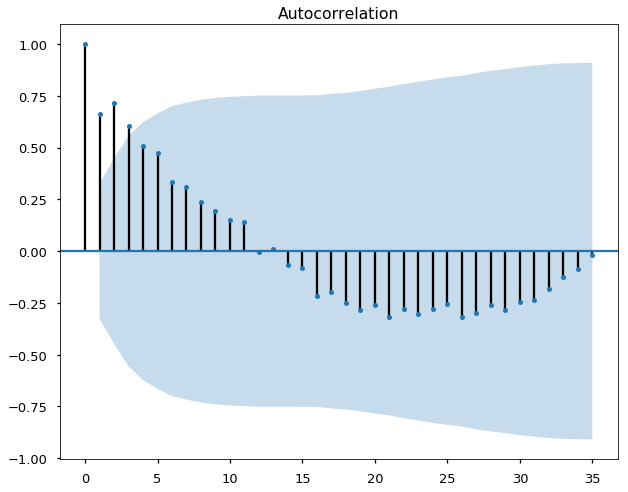

In [8]:
# a different way to plot the autocorrelation from [2]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)

Observation: Time steps are 1 month long and with 3 years that gives 36 time steps, or number of lags in the figure. The sales autocorrelates positively at a lag of up to about 10-12. **"A good starting point for the AR parameter of the model may be 5."**

In [13]:
# fit ARIMA model with lag = 5, difference order = 1, moving average model = 0.
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = DataFrame(model_fit.resid)
print('RESIDUALS:')
print(residuals.describe())

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Mon, 07 Jan 2019   AIC                            406.340
Time:                                                 10:50:05   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

/home/karen/code/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/karen/code/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


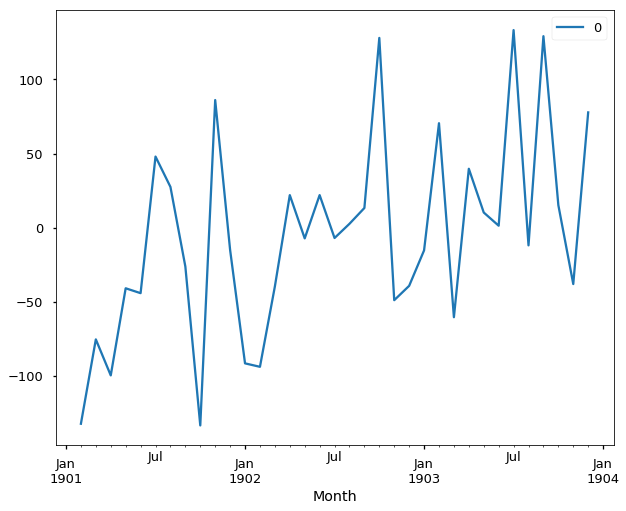

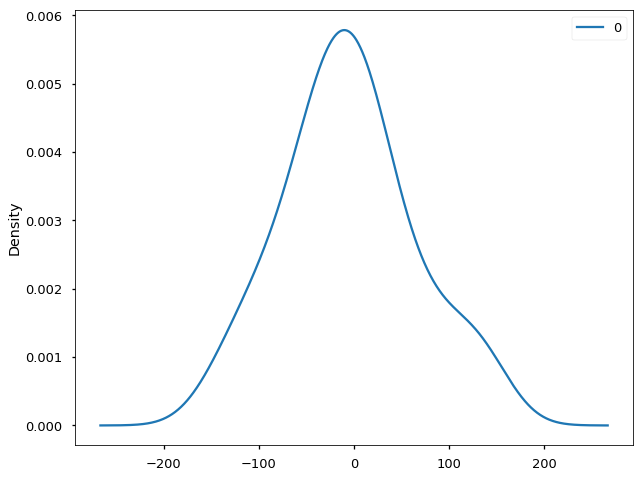

In [14]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde') # plots Kernel Density Estimate plot using Gaussian kernels.
plt.show()

Observations: **"The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)."**

In [24]:
# Example of a rolling forecast, using the first 66% datapoints for training, the rest for testing.
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=349.117636, expected=342.300000
predicted=306.513010, expected=339.700000
predicted=387.376466, expected=440.400000
predicted=348.154255, expected=315.900000
predicted=386.308811, expected=439.300000
predicted=356.082029, expected=401.300000
predicted=446.379518, expected=437.400000
predicted=394.737277, expected=575.500000
predicted=434.915541, expected=407.600000
predicted=507.923456, expected=682.000000
predicted=435.482818, expected=475.300000
predicted=652.743768, expected=581.300000
predicted=546.343465, expected=646.900000
Test MSE: 6958.326


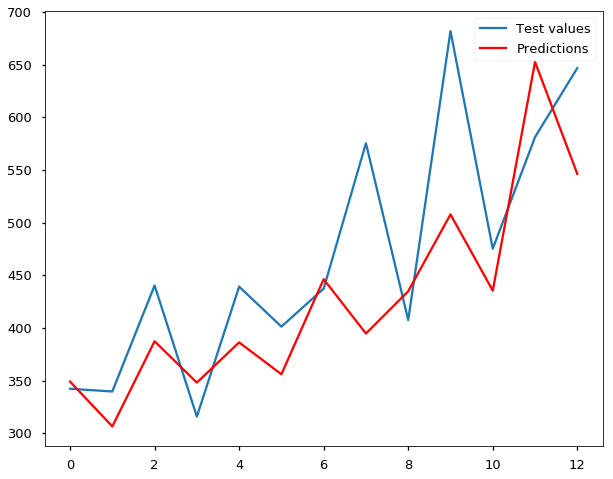

In [16]:
# plot resulting predictions compared to ideal test values
plt.plot(test,label='Test values')
plt.plot(predictions, color='red',label='Predictions')
plt.legend()
plt.show()

In [17]:
# output from forecast method also gives stderr and confidence interval:
output

(array([546.34346493]),
 array([63.45598398]),
 array([[421.97202173, 670.71490813]]))

In [18]:
# Akaike Information Criterion - a goodness of fit criterion, one for each test value.
# The smaller the better: https://en.wikipedia.org/wiki/Akaike_information_criterion
# Included in model_fit.summary(). Last one here is:
model_fit.aic

394.27262823595385

In [19]:
import itertools
p=d=q=range(0,6)
pdq = list(itertools.product(p,d,q))

In [20]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model = ARIMA(history, order=param)
        model_fit = model.fit(disp=0)
        print(param,model_fit.aic)
    except:
        continue

(0, 0, 0) 465.4031867987385
(0, 0, 1) 457.17459055972273
(0, 0, 2) 444.70601763231656
(0, 0, 3) 442.39513901014396
(0, 0, 4) nan
(0, 0, 5) nan
(0, 1, 0) 430.87311187552797
(0, 1, 1) 409.0126622411526
(0, 2, 0) 461.1578257086931
(0, 2, 1) 424.58251674821
(1, 0, 0) 442.1571606570998
(1, 0, 1) 444.5908941656262
(1, 1, 0) 406.02228959235015
(1, 1, 1) 402.4666524179953
(1, 1, 2) 401.5247943798928
(1, 1, 3) 403.52417287508956
(1, 2, 0) 423.90008603782104
(1, 2, 3) nan
(1, 2, 4) nan
(2, 0, 0) 423.46489536267086
(2, 1, 0) 403.6275641166603
(2, 1, 1) 404.28621423318384
(2, 2, 0) 412.99938249704275
(2, 2, 1) 396.65262382813955
(2, 2, 3) 389.68350650892074
(3, 0, 0) 423.4645610285194
(3, 1, 0) 404.6924591816878
(3, 1, 1) 406.1395443929549
(3, 2, 0) 410.9109265845758
(3, 2, 1) 396.30623658353767
(3, 2, 2) nan
(3, 2, 3) 406.104929451703
(4, 1, 0) 404.78676855669903
(4, 1, 1) 406.5796403612012
(4, 1, 2) 400.2307795387626
(4, 1, 3) 400.65677258685764
(4, 1, 4) 406.3808484357497
(4, 2, 0) 403.94822895

Observation: (4,2,1) seems to give the best result:

In [25]:
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
new_predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    new_predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, new_predictions)
print('Test MSE: %.3f' % error)

predicted=399.145200, expected=342.300000
predicted=354.296566, expected=339.700000
predicted=429.967876, expected=440.400000
predicted=392.634689, expected=315.900000
predicted=420.191849, expected=439.300000
predicted=397.585316, expected=401.300000
predicted=487.892625, expected=437.400000
predicted=434.160085, expected=575.500000
predicted=467.057786, expected=407.600000
predicted=568.082759, expected=682.000000
predicted=468.024731, expected=475.300000
predicted=687.491691, expected=581.300000
predicted=617.839224, expected=646.900000
Test MSE: 4694.875


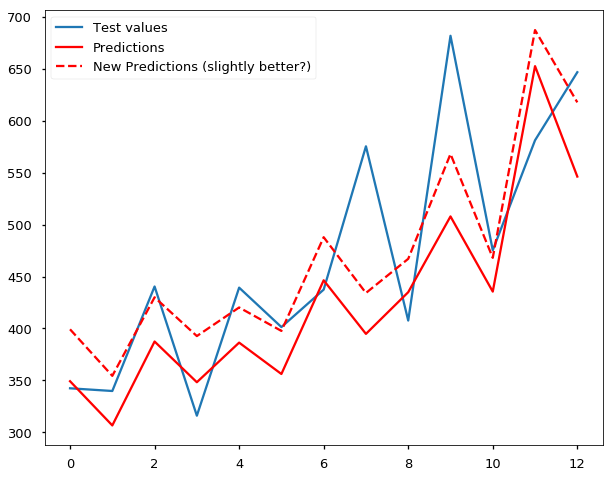

In [27]:
# plot resulting predictions compared to ideal test values
plt.plot(test,label='Test values')
plt.plot(predictions, color='red',label='Predictions')
plt.plot(new_predictions, color='red',ls='--', label='New Predictions (slightly better?)')
plt.legend()
plt.show()